In [1]:
%load_ext kedro.extras.extensions.ipython

The kedro.extras.extensions.ipython extension is already loaded. To reload it, use:
  %reload_ext kedro.extras.extensions.ipython


In [2]:
%reload_kedro

2022-08-22 15:05:57,262 - kedro.framework.hooks.manager - INFO - Registered hooks from 1 installed plugin(s): kedro-mlflow-0.8.1
2022-08-22 15:05:57,308 - kedro.framework.session.store - INFO - `read()` not implemented for `BaseSessionStore`. Assuming empty store.
2022-08-22 15:05:57,812 - root - INFO - ** Kedro project GetInData ML Framework
2022-08-22 15:05:57,813 - root - INFO - Defined global variable `context`, `session`, `catalog` and `pipelines`
2022-08-22 15:05:57,822 - root - INFO - Registered line magic `run_viz`
2022-08-22 15:05:57,823 - root - INFO - Registered line magic `reload_kedro_mlflow`


In [3]:
import pandas as pd
import numpy as np

In [4]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [5]:
catalog.list()

['articles',
 'customers',
 'transactions',
 'customers_sample',
 'transactions_sample',
 'articles_sample',
 'input_images',
 'resized_images',
 'image_embeddings',
 'text_embeddings',
 'candidates_sample',
 'val_transactions',
 'automated_articles_features',
 'automated_customers_features',
 'manual_article_features',
 'manual_customer_features',
 'manual_customer_prod_group_features',
 'jaccard_similarity_features',
 'image_cosine_similarity_features',
 'text_cosine_similarity_features',
 'candidates_similarity_features',
 'parameters',
 'params:automated_feature_engineering',
 'params:automated_feature_engineering.articles',
 'params:automated_feature_engineering.articles.feature_selection',
 'params:automated_feature_engineering.articles.feature_selection_params',
 'params:automated_feature_engineering.articles.feature_selection_params.pct_null_threshold',
 'params:automated_feature_engineering.articles.feature_selection_params.corr_threshold',
 'params:automated_feature_engineeri

In [6]:
[data for data in catalog.list() if not data.startswith('params:')]

['articles',
 'customers',
 'transactions',
 'customers_sample',
 'transactions_sample',
 'articles_sample',
 'input_images',
 'resized_images',
 'image_embeddings',
 'text_embeddings',
 'candidates_sample',
 'val_transactions',
 'automated_articles_features',
 'automated_customers_features',
 'manual_article_features',
 'manual_customer_features',
 'manual_customer_prod_group_features',
 'jaccard_similarity_features',
 'image_cosine_similarity_features',
 'text_cosine_similarity_features',
 'candidates_similarity_features',
 'parameters']

### loading data

In [7]:
candidates = context.catalog.load('candidates_similarity_features')

2022-08-22 15:05:57,864 - kedro.io.data_catalog - INFO - Loading data from `candidates_similarity_features` (ParquetDataSet)...


In [8]:
val_transactions = context.catalog.load('val_transactions')

2022-08-22 15:06:02,437 - kedro.io.data_catalog - INFO - Loading data from `val_transactions` (CSVDataSet)...


In [9]:
val_transactions = val_transactions[['customer_id', 'article_id']].assign(label=lambda x: 1)

In [10]:
val_transactions.shape

(4461, 3)

In [11]:
val_transactions.head()

,customer_id,article_id,label
0,017f1c01901a5113dffb00e2ff99024a99915d3cd86af4...,0916256001,1
1,01a39571fd15b542ac4832adcd4b80962823ee855a398a...,0855706004,1
2,02c8d36c490fc65c03d720c1220694573c34006cdcc2f9...,0903473003,1
3,0329f6a6682ad231723108c556d0861d8ff8a2fc5d843e...,0946764002,1
4,051aa83b1a3978fa888ae1d5a05e7eccceff95e00f7d7f...,0863692003,1


In [12]:
candidates = candidates.merge(val_transactions, on=['customer_id', 'article_id'], how='left').fillna({'label': 0})

In [13]:
candidates['label'] = candidates['label'].astype(int)

### filter

In [14]:
user_ids = list(candidates.customer_id.unique())[:10_000]

In [15]:
candidates = candidates[candidates.customer_id.isin(user_ids)]

In [16]:
candidates.shape

(3346992, 7)

### downsampling (not used right now)

i mean, it doesn't make sense, 2 millions negative samples = 14.5 per CUSTOMER, so basically we are randomly choosing articles for each customer. Doesn't make sense

In [17]:
neg_samples = 2_000_000
seed = 42

In [21]:
candidates = pd.concat([candidates[candidates['label']>0],
                        candidates[candidates['label']==0].sample(neg_samples, random_state=42)], axis=0)

In [24]:
2_000_000/137_198

14.577471974810129

In [22]:
candidates.shape

(2004461, 7)

In [23]:
candidates.customer_id.nunique()

137198

### continue

In [17]:
candidates.shape

(3346992, 7)

In [18]:
candidates.customer_id.nunique()

10000

In [19]:
candidates.head()

,customer_id,article_id,strategy_name,articles_jaccard_similarity,image_cosine_similarity,text_cosine_similarity,label
0,ff18c106287931d170618b59fd402ed0ecc292869aad5f...,0554479001,global_articles,0.0000,0.0000,0.0000,0
1,ff18c106287931d170618b59fd402ed0ecc292869aad5f...,0904571001,multiple_strategies,0.0000,0.0000,0.0000,0
2,ff18c106287931d170618b59fd402ed0ecc292869aad5f...,0869331006,multiple_strategies,0.0000,0.0000,0.0000,0
3,ff18c106287931d170618b59fd402ed0ecc292869aad5f...,0792469001,multiple_strategies,0.0000,0.0000,0.0000,0
4,ff18c106287931d170618b59fd402ed0ecc292869aad5f...,0902528006,multiple_strategies,0.0000,0.0000,0.0000,0


### optimizing data

In [20]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64',
               # fucking pandas types
                'Int16', 'Int32', 'Int64', 'Float16', 'Float32', 'Float64'
               ]
    start_mem = df.memory_usage().sum() / 1024**2
    print(f'Starting usage memory: {start_mem:.2f}')

    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type).lower()[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np. float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        # if col_type == 'object':
            # here
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [21]:
candidates = reduce_mem_usage(candidates)

Starting usage memory: 204.28
Mem. usage decreased to 143.64 Mb (29.7% reduction)


### regex

In [22]:
import re

In [23]:
count_pattern = '^[Cc][Oo][Uu][Nn][Tt]'

In [24]:
def fill_na_int(df, regex_pattern, fill_na_value):
    cols = [col for col in df.columns if re.match(regex_pattern, col)]
    df.loc[:, cols] = df.loc[:, cols].fillna(fill_na_value).astype(int)
    return df

### not now

##### customer_id optimization -> index -> customer_id (mapping)
id_to_index_dict = dict(zip(customers["customer_id"], customers.index))
index_to_id_dict = dict(zip(customers.index, customers["customer_id"]))

#for memory efficiency
transactions["customer_id"] = transactions["customer_id"].map(id_to_index_dict)

#for switching back for submission
sub["customer_id"] = sub["customer_id"].map(index_to_id_dict)

###### article_id optimization str -> int32 -> str
train['article_id'] = train.article_id.astype('int32')
train['article_id'] = '0' + train.article_id.astype('str')

In [15]:
candidates['article_id'] = candidates['article_id'].astype('int32')

In [20]:
candidates.memory_usage().sum() / 1024**2

1750.9048461914062

### continue

### articles

In [25]:
automated_articles_features = context.catalog.load('automated_articles_features')

2022-08-22 15:06:19,317 - kedro.io.data_catalog - INFO - Loading data from `automated_articles_features` (ParquetDataSet)...


In [26]:
manual_article_features = context.catalog.load('manual_article_features')

2022-08-22 15:06:19,351 - kedro.io.data_catalog - INFO - Loading data from `manual_article_features` (ParquetDataSet)...


In [27]:
automated_articles_features = fill_na_int(automated_articles_features, count_pattern, 0)

In [28]:
automated_articles_features.shape, manual_article_features.shape

((21108, 37), (6780, 2))

In [29]:
automated_articles_features.dtypes

COUNT(transactions)_7                       int64
MAX(transactions.price)_7                 float64
MIN(transactions.price)_7                 float64
SUM(transactions.price)_7                 float64
NUM_CHARACTERS(detail_desc)_7             float64
NUM_WORDS(detail_desc)_7                  float64
MAX(transactions.customers.age)_7         float64
MEAN(transactions.customers.age)_7        float64
MEDIAN(transactions.customers.age)_7      float64
MIN(transactions.customers.age)_7         float64
SUM(transactions.customers.age)_7         float64
COUNT(transactions)_30                      int64
MAX(transactions.price)_30                float64
MIN(transactions.price)_30                float64
SUM(transactions.price)_30                float64
MAX(transactions.customers.age)_30        float64
MEAN(transactions.customers.age)_30       float64
MEDIAN(transactions.customers.age)_30     float64
MIN(transactions.customers.age)_30        float64
COUNT(transactions)_90                      int64


In [30]:
automated_articles_features = reduce_mem_usage(automated_articles_features)

Starting usage memory: 6.66
Mem. usage decreased to  3.50 Mb (47.4% reduction)


In [31]:
automated_articles_features.dtypes

COUNT(transactions)_7                        int8
MAX(transactions.price)_7                 float32
MIN(transactions.price)_7                 float32
SUM(transactions.price)_7                 float32
NUM_CHARACTERS(detail_desc)_7             float32
NUM_WORDS(detail_desc)_7                  float32
MAX(transactions.customers.age)_7         float32
MEAN(transactions.customers.age)_7        float32
MEDIAN(transactions.customers.age)_7      float32
MIN(transactions.customers.age)_7         float32
SUM(transactions.customers.age)_7         float32
COUNT(transactions)_30                      int16
MAX(transactions.price)_30                float32
MIN(transactions.price)_30                float32
SUM(transactions.price)_30                float32
MAX(transactions.customers.age)_30        float32
MEAN(transactions.customers.age)_30       float32
MEDIAN(transactions.customers.age)_30     float32
MIN(transactions.customers.age)_30        float32
COUNT(transactions)_90                      int16


In [32]:
manual_article_features.dtypes

perc_rebought                 float64
perc_article_sales_offline    float64
dtype: object

In [33]:
manual_article_features = reduce_mem_usage(manual_article_features)

Starting usage memory: 0.16
Mem. usage decreased to  0.10 Mb (33.3% reduction)


In [34]:
manual_article_features.dtypes

perc_rebought                 float32
perc_article_sales_offline    float32
dtype: object

In [35]:
candidates = candidates.merge(automated_articles_features, how='left', on='article_id').merge(manual_article_features, how='left', on='article_id')

In [36]:
import gc

In [37]:
del automated_articles_features
gc.collect()

1561

In [38]:
del manual_article_features
gc.collect()

0

In [39]:
candidates.shape

(3346992, 46)

### customers

In [40]:
automated_customers_features = context.catalog.load('automated_customers_features')

2022-08-22 15:06:21,002 - kedro.io.data_catalog - INFO - Loading data from `automated_customers_features` (ParquetDataSet)...


In [41]:
manual_customer_features = context.catalog.load('manual_customer_features')

2022-08-22 15:06:21,079 - kedro.io.data_catalog - INFO - Loading data from `manual_customer_features` (ParquetDataSet)...


In [42]:
automated_customers_features = fill_na_int(automated_customers_features, count_pattern, 0)

In [43]:
manual_customer_features = fill_na_int(manual_customer_features, count_pattern, 0)

In [44]:
automated_customers_features.dtypes

COUNT(transactions)_7               int64
SUM(transactions.price)_7         float64
COUNT(transactions)_30              int64
MAX(transactions.price)_30        float64
MEAN(transactions.price)_30       float64
MEDIAN(transactions.price)_30     float64
MIN(transactions.price)_30        float64
SUM(transactions.price)_30        float64
COUNT(transactions)_90              int64
MAX(transactions.price)_90        float64
MEAN(transactions.price)_90       float64
MEDIAN(transactions.price)_90     float64
MIN(transactions.price)_90        float64
SUM(transactions.price)_90        float64
COUNT(transactions)_all             int64
MAX(transactions.price)_all       float64
MEAN(transactions.price)_all      float64
MEDIAN(transactions.price)_all    float64
MIN(transactions.price)_all       float64
SUM(transactions.price)_all       float64
dtype: object

In [45]:
automated_customers_features = reduce_mem_usage(automated_customers_features)

Starting usage memory: 26.54
Mem. usage decreased to 14.50 Mb (45.4% reduction)


In [46]:
automated_customers_features.dtypes

COUNT(transactions)_7                int8
SUM(transactions.price)_7         float32
COUNT(transactions)_30               int8
MAX(transactions.price)_30        float32
MEAN(transactions.price)_30       float32
MEDIAN(transactions.price)_30     float32
MIN(transactions.price)_30        float32
SUM(transactions.price)_30        float32
COUNT(transactions)_90               int8
MAX(transactions.price)_90        float32
MEAN(transactions.price)_90       float32
MEDIAN(transactions.price)_90     float32
MIN(transactions.price)_90        float32
SUM(transactions.price)_90        float32
COUNT(transactions)_all              int8
MAX(transactions.price)_all       float32
MEAN(transactions.price)_all      float32
MEDIAN(transactions.price)_all    float32
MIN(transactions.price)_all       float32
SUM(transactions.price)_all       float32
dtype: object

In [47]:
manual_customer_features.dtypes

days_since_first_transaction                      int64
days_since_last_transaction                       int64
avg_purchase_span                               float64
perc_customer_sales_offline                     float64
count_of_article_per_customer_7                   int64
count_of_product_group_name_per_customer_7        int64
count_of_article_per_customer_30                  int64
count_of_product_group_name_per_customer_30       int64
count_of_article_per_customer_90                  int64
count_of_product_group_name_per_customer_90       int64
count_of_article_per_customer_all                 int64
count_of_product_group_name_per_customer_all      int64
dtype: object

In [48]:
manual_customer_features = reduce_mem_usage(manual_customer_features)

Starting usage memory: 4.87
Mem. usage decreased to  1.31 Mb (73.1% reduction)


In [49]:
manual_customer_features.dtypes

days_since_first_transaction                      int16
days_since_last_transaction                       int16
avg_purchase_span                               float32
perc_customer_sales_offline                     float32
count_of_article_per_customer_7                    int8
count_of_product_group_name_per_customer_7         int8
count_of_article_per_customer_30                   int8
count_of_product_group_name_per_customer_30        int8
count_of_article_per_customer_90                   int8
count_of_product_group_name_per_customer_90        int8
count_of_article_per_customer_all                  int8
count_of_product_group_name_per_customer_all       int8
dtype: object

In [50]:
manual_customer_features.isna().sum()

days_since_first_transaction                        0
days_since_last_transaction                         0
avg_purchase_span                               26957
perc_customer_sales_offline                         0
count_of_article_per_customer_7                     0
count_of_product_group_name_per_customer_7          0
count_of_article_per_customer_30                    0
count_of_product_group_name_per_customer_30         0
count_of_article_per_customer_90                    0
count_of_product_group_name_per_customer_90         0
count_of_article_per_customer_all                   0
count_of_product_group_name_per_customer_all        0
dtype: int64

In [51]:
automated_customers_features.shape, manual_customer_features.shape

((137198, 20), (49145, 12))

In [52]:
candidates = candidates.merge(automated_customers_features, how='left', on='customer_id').merge(manual_customer_features, how='left', on='customer_id')

In [53]:
candidates = fill_na_int(candidates, count_pattern, 0)

In [54]:
candidates = reduce_mem_usage(candidates)

Starting usage memory: 1279.97
Mem. usage decreased to 906.51 Mb (29.2% reduction)


In [55]:
del automated_customers_features
gc.collect()

44

In [56]:
del manual_customer_features
gc.collect()

0

In [57]:
candidates.shape

(3346992, 78)

In [58]:
pd.set_option('display.max_rows', None)

In [59]:
candidates.dtypes

customer_id                                      object
article_id                                       object
strategy_name                                    object
articles_jaccard_similarity                     float32
image_cosine_similarity                         float32
text_cosine_similarity                          float32
label                                              int8
COUNT(transactions)_7_x                            int8
MAX(transactions.price)_7                       float32
MIN(transactions.price)_7                       float32
SUM(transactions.price)_7_x                     float32
NUM_CHARACTERS(detail_desc)_7                   float32
NUM_WORDS(detail_desc)_7                        float32
MAX(transactions.customers.age)_7               float32
MEAN(transactions.customers.age)_7              float32
MEDIAN(transactions.customers.age)_7            float32
MIN(transactions.customers.age)_7               float32
SUM(transactions.customers.age)_7               

In [60]:
pd.set_option('display.max_rows', 10)

In [61]:
candidates['strategy_name'] = candidates['strategy_name'].astype('category')

In [62]:
candidates.memory_usage().sum() / 1024**2

884.1676750183105

### dictionary features

In [63]:
articles = context.catalog.load('articles')

2022-08-22 15:06:28,659 - kedro.io.data_catalog - INFO - Loading data from `articles` (CSVDataSet)...


In [64]:
customers = context.catalog.load('customers')

2022-08-22 15:06:28,975 - kedro.io.data_catalog - INFO - Loading data from `customers` (CSVDataSet)...


In [65]:
drop_cols_articles = ['prod_name', 'product_type_name', 'graphical_appearance_name', 'colour_group_name', 'perceived_colour_value_name', 'perceived_colour_master_name', 'index_name', 'index_group_name', 'section_name', 'garment_group_name', 'detail_desc']

In [66]:
# these cols are just the same values as _no (OR SIMILAR, HAVEN'T CHECKED) but mostly DUPLICATES
articles.drop(drop_cols_articles, axis=1, inplace=True)

In [67]:
articles.dtypes

article_id                 object
product_code                int64
product_type_no             int64
product_group_name         object
graphical_appearance_no     int64
                            ...  
department_name            object
index_code                 object
index_group_no              int64
section_no                  int64
garment_group_no            int64
Length: 14, dtype: object

In [68]:
articles = reduce_mem_usage(articles)

Starting usage memory: 11.27
Mem. usage decreased to  5.13 Mb (54.5% reduction)


In [69]:
articles.dtypes

article_id                 object
product_code                int32
product_type_no             int16
product_group_name         object
graphical_appearance_no     int32
                            ...  
department_name            object
index_code                 object
index_group_no               int8
section_no                   int8
garment_group_no            int16
Length: 14, dtype: object

In [70]:
customers.dtypes

customer_id                object
FN                        float64
Active                    float64
club_member_status         object
fashion_news_frequency     object
age                       float64
postal_code                object
dtype: object

In [71]:
customers = reduce_mem_usage(customers)

Starting usage memory: 73.27
Mem. usage decreased to 57.57 Mb (21.4% reduction)


In [72]:
customers.dtypes

customer_id                object
FN                        float32
Active                    float32
club_member_status         object
fashion_news_frequency     object
age                       float32
postal_code                object
dtype: object

In [73]:
candidates = candidates.merge(customers, how='left', on='customer_id')

In [74]:
del customers
gc.collect()

44

In [75]:
candidates = candidates.merge(articles, how='left', on='article_id')

In [76]:
del articles
gc.collect()

0

In [77]:
candidates = reduce_mem_usage(candidates)

Starting usage memory: 1136.33
Mem. usage decreased to 1136.33 Mb (0.0% reduction)


In [78]:
candidates.shape

(3346992, 97)

In [79]:
candidates.loc[:, ['index_code', 'club_member_status',
       'fashion_news_frequency', 'postal_code', 'product_group_name',
       'department_name', 'FN', 'Active']] = candidates.loc[:, ['index_code',
                                                                'club_member_status',
       'fashion_news_frequency', 'postal_code', 'product_group_name',
       'department_name', 'FN', 'Active']].astype('category')

In [80]:
pd.set_option('display.max_rows', None)

In [81]:
candidates.dtypes

customer_id                                       object
article_id                                        object
strategy_name                                   category
articles_jaccard_similarity                      float32
image_cosine_similarity                          float32
text_cosine_similarity                           float32
label                                               int8
COUNT(transactions)_7_x                             int8
MAX(transactions.price)_7                        float32
MIN(transactions.price)_7                        float32
SUM(transactions.price)_7_x                      float32
NUM_CHARACTERS(detail_desc)_7                    float32
NUM_WORDS(detail_desc)_7                         float32
MAX(transactions.customers.age)_7                float32
MEAN(transactions.customers.age)_7               float32
MEDIAN(transactions.customers.age)_7             float32
MIN(transactions.customers.age)_7                float32
SUM(transactions.customers.age)

In [82]:
pd.set_option('display.max_rows', 10)

In [83]:
candidates.memory_usage().sum() / 1024**2

989.833179473877

### why would anybody do that?

lol, bad

In [54]:
candidates = candidates.convert_dtypes(convert_string=False, convert_floating=False)

In [55]:
candidates.memory_usage().sum() / 1024**2

9676.534309387207

### import lightgbm

In [84]:
import lightgbm as lgb

In [85]:
candidates.select_dtypes(include='category').columns

Index(['strategy_name', 'FN', 'Active', 'club_member_status',
       'fashion_news_frequency', 'postal_code', 'product_group_name',
       'department_name', 'index_code'],
      dtype='object')

In [86]:
# train positive rate
candidates.label.mean() * 10

0.0009560823569342263

# 
ignore customers with full negative samples
candidates.groupby(['customer_id'])['label'].max().reset_index().where()

In [87]:
features = [col for col in candidates.columns if col not in ['label', 'customer_id', 'article_id']]

In [88]:
cat_features = candidates.select_dtypes(include='category').columns.to_list()

In [89]:
cat_features = ['strategy_name',
 'FN',
 'Active',
 'club_member_status',
 'fashion_news_frequency',
 'postal_code',
 'product_group_name',
 'department_name',
 'index_code']

In [90]:
cat_features

['strategy_name',
 'FN',
 'Active',
 'club_member_status',
 'fashion_news_frequency',
 'postal_code',
 'product_group_name',
 'department_name',
 'index_code']

In [91]:
params = {
    "objective": "lambdarank",
    "boosting_type": "gbdt",
    "metric": "map",
    "max_depth": 8,
    "num_leaves": 128,
    "learning_rate": 0.03,
    "verbose": -1,
    "eval_at": 12,
    # 'device':'gpu'
}

In [92]:
validation_customers = pd.DataFrame(candidates.customer_id.unique()).sample(frac=0.2).iloc[:, 0].values

In [93]:
len(validation_customers)

2000

In [94]:
train_candidates = candidates[~(candidates.customer_id.isin(validation_customers))]
val_candidates = candidates[candidates.customer_id.isin(validation_customers)]

In [95]:
train_candidates.shape, val_candidates.shape

((2677606, 97), (669386, 97))

In [96]:
train_candidates.customer_id.nunique(), val_candidates.customer_id.nunique()

(8000, 2000)

##### groups

In [97]:
train_group = train_candidates[['customer_id', 'article_id']]

In [98]:
train_group = train_group.groupby(['customer_id']).size().values

In [99]:
val_group = val_candidates[['customer_id', 'article_id']]

In [100]:
val_group = val_group.groupby(['customer_id']).size().values

##### datasets

In [101]:
train_set = lgb.Dataset(
        data=train_candidates[features],
        label=train_candidates["label"],
        group=train_group,
        feature_name=features,
        categorical_feature=cat_features,
        params=params,
    )

In [102]:
val_set = lgb.Dataset(
        data=val_candidates[features],
        label=val_candidates["label"],
        group=val_group,
        feature_name=features,
        categorical_feature=cat_features,
        params=params,
    )

del candidates
gc.collect()

In [103]:
ranker = lgb.train(
        params,
        train_set,
        valid_sets=[val_set],
        num_boost_round=30,
    )

/Users/mmadej/Desktop/Projects/gid-ml-framework/.venv/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/mmadej/Desktop/Projects/gid-ml-framework/.venv/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/mmadej/Desktop/Projects/gid-ml-framework/.venv/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's map@12: 0.990436
[2]	valid_0's map@12: 0.993439
[3]	valid_0's map@12: 0.994622
[4]	valid_0's map@12: 0.995803
[5]	valid_0's map@12: 0.996042
[6]	valid_0's map@12: 0.996086
[7]	valid_0's map@12: 0.996132
[8]	valid_0's map@12: 0.995635
[9]	valid_0's map@12: 0.995471
[10]	valid_0's map@12: 0.995491
[11]	valid_0's map@12: 0.995782
[12]	valid_0's map@12: 0.995719
[13]	valid_0's map@12: 0.995764
[14]	valid_0's map@12: 0.995777
[15]	valid_0's map@12: 0.995519
[16]	valid_0's map@12: 0.995648
[17]	valid_0's map@12: 0.995654
[18]	valid_0's map@12: 0.995604
[19]	valid_0's map@12: 0.995582
[20]	valid_0's map@12: 0.995582
[21]	valid_0's map@12: 0.99561
[22]	valid_0's map@12: 0.995619
[23]	valid_0's map@12: 0.995656
[24]	valid_0's map@12: 0.995671
[25]	valid_0's map@12: 0.995648
[26]	valid_0's map@12: 0.995648
[27]	valid_0's map@12: 0.995898
[28]	valid_0's map@12: 0.996186
[29]	valid_0's map@12: 0.996186
[30]	valid_0's map@12: 0.996186


In [104]:
ranker

In [105]:
feat_importance = pd.DataFrame(
    {"feature": features, "importance": ranker.feature_importance()}
).sort_values(by="importance", ascending=False)

In [106]:
import matplotlib.pyplot as plt
import seaborn as sns

/Users/mmadej/Desktop/Projects/gid-ml-framework/.venv/lib/python3.8/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/Users/mmadej/Desktop/Projects/gid-ml-framework/.venv/lib/python3.8/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


<AxesSubplot:xlabel='importance', ylabel='feature'>

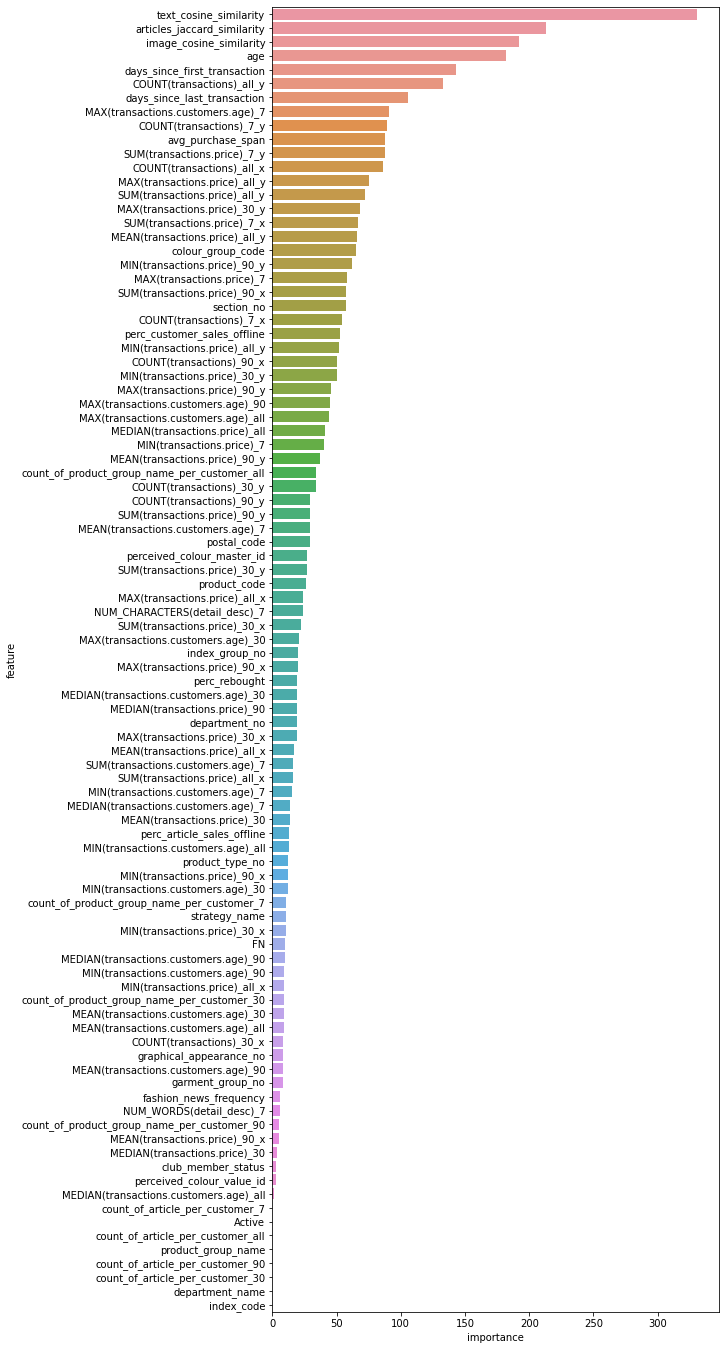

In [107]:
plt.figure(figsize=(8, 24))
sns.barplot(y="feature", x="importance", data=feat_importance)

In [108]:
def predict(ranker, candidates, batch_size = 1_000_000):
    probs = np.zeros(candidates.shape[0])
    for batch in range(0, candidates.shape[0], batch_size):
        outputs = ranker.predict(candidates.loc[batch : batch + batch_size - 1, features])
        probs[batch : batch + batch_size] = outputs
    candidates["prob"] = probs
    pred_lgb = candidates[['customer_id', 'article_id', 'prob']]
    pred_lgb = pred_lgb.sort_values(by=['customer_id', 'prob'], ascending=False).reset_index(drop=True)
    pred_lgb.rename(columns={'article_id': 'prediction'}, inplace=True)
    pred_lgb = pred_lgb.drop_duplicates(['customer_id', 'prediction'], keep='first')
    pred_lgb = pred_lgb.groupby("customer_id")["prediction"].apply(list).reset_index()
    return pred_lgb

In [109]:
pred = predict(ranker, val_candidates)

ValueError: could not broadcast input array from shape (205582,) into shape (669386,)

In [111]:
pred

,customer_id,prediction
0,0003e56a4332b2503e34640be92031ad48f1280ee6e3a7...,[]
1,0006a10483f4b1d47dd0c640429a1c059f224c3a87464c...,[]
2,000df6cf5f902e6bb2a45b94d96c82c62324fe04bea329...,[]
3,00208fb274f1f5a739702ce60ed1bf6106910fa990b4bc...,[]
4,003292a63d9ca49d46dd66ffbbd6cca6e02f50f6b5f488...,[]
...,...,...
9995,ffe98d88192feecce39e53d5f0cfa5343e3a1b51677e1d...,[]
9996,fff187d1386edced8ef49b1df0155241943c9c4cc7abbf...,[]
9997,fff62d5b7df1ffc31c733ccf4b59af21d645e2b2d11256...,[]
9998,fff69e3ab1bd701315881c7706c38d5cbcda1f4e0cf213...,[]


In [110]:
probs = np.zeros(val_candidates.shape[0])

In [111]:
probs

array([0., 0., 0., ..., 0., 0., 0.])

In [112]:
for batch in range(0, val_candidates.shape[0], 5_000_000):
    outputs = ranker.predict(val_candidates.loc[batch : batch + 5_000_000 - 1, features])
    probs[batch : batch + 5_000_000] = outputs

In [113]:
val_candidates["prob"] = probs

/var/folders/dl/55k0mmrx765_h9n3c5rmqz8c0000gn/T/ipykernel_5583/3238427657.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_candidates["prob"] = probs


In [114]:
pred_lgb = val_candidates[['customer_id', 'article_id', 'prob']].sort_values(by=['customer_id', 'prob'], ascending=False).reset_index(drop=True)

In [115]:
pred_lgb

,customer_id,article_id,prob
0,fff62d5b7df1ffc31c733ccf4b59af21d645e2b2d11256...,0554479001,-1.2214
1,fff62d5b7df1ffc31c733ccf4b59af21d645e2b2d11256...,0904571001,-1.2214
2,fff62d5b7df1ffc31c733ccf4b59af21d645e2b2d11256...,0869331006,-1.2214
3,fff62d5b7df1ffc31c733ccf4b59af21d645e2b2d11256...,0792469001,-1.2214
4,fff62d5b7df1ffc31c733ccf4b59af21d645e2b2d11256...,0902528006,-1.2214
...,...,...,...
669381,0003e56a4332b2503e34640be92031ad48f1280ee6e3a7...,0579541086,-1.2215
669382,0003e56a4332b2503e34640be92031ad48f1280ee6e3a7...,0863565004,-1.2215
669383,0003e56a4332b2503e34640be92031ad48f1280ee6e3a7...,0720504008,-1.2215
669384,0003e56a4332b2503e34640be92031ad48f1280ee6e3a7...,0907951001,-1.2215


In [116]:
pred_lgb.prob.describe()

count   669386.0000
mean        -1.2203
std          0.0497
min         -1.3059
25%         -1.2225
50%         -1.2215
75%         -1.2215
max          1.2125
Name: prob, dtype: float64

In [117]:
pred_lgb = pred_lgb.groupby(['customer_id']).head(12)

pred_lgb.loc[:, ['customer_id', 'article_id']] = pred_lgb.loc[:, ['customer_id', 'article_id']].astype(str)

In [118]:
pred_lgb.customer_id.nunique()

2000

In [119]:
pred_lgb.head(13)

,customer_id,article_id,prob
0,fff62d5b7df1ffc31c733ccf4b59af21d645e2b2d11256...,0554479001,-1.2214
1,fff62d5b7df1ffc31c733ccf4b59af21d645e2b2d11256...,0904571001,-1.2214
2,fff62d5b7df1ffc31c733ccf4b59af21d645e2b2d11256...,0869331006,-1.2214
3,fff62d5b7df1ffc31c733ccf4b59af21d645e2b2d11256...,0792469001,-1.2214
4,fff62d5b7df1ffc31c733ccf4b59af21d645e2b2d11256...,0902528006,-1.2214
...,...,...,...
8,fff62d5b7df1ffc31c733ccf4b59af21d645e2b2d11256...,0832481002,-1.2214
9,fff62d5b7df1ffc31c733ccf4b59af21d645e2b2d11256...,0688728023,-1.2214
10,fff62d5b7df1ffc31c733ccf4b59af21d645e2b2d11256...,0158340001,-1.2214
11,fff62d5b7df1ffc31c733ccf4b59af21d645e2b2d11256...,0706016015,-1.2214


In [120]:
pred_lgb.groupby(['customer_id'])['article_id'].apply(list).reset_index()

,customer_id,article_id
0,0003e56a4332b2503e34640be92031ad48f1280ee6e3a7...,"[0554479001, 0904571001, 0869331006, 079246900..."
1,000df6cf5f902e6bb2a45b94d96c82c62324fe04bea329...,"[0907951001, 0867994001, 0831269009, 090402600..."
2,0065848cb03f4147bfe8f8c4c5ae3fce496ad9c3389fc3...,"[0832473001, 0861514001, 0783346020, 076346900..."
3,009ce0498e522ba4d20a80b7aaecd8567b15b52eb78c0c...,"[0907951001, 0867994001, 0831269009, 090402600..."
4,00cd746a1260bc81b14b21a23e29fd520b37cd32d92b09...,"[0554479001, 0904571001, 0869331006, 079246900..."
...,...,...
1995,ff4a33dfcf512d6beb354aef28c2d8a2b4cc690db15817...,"[0554479001, 0904571001, 0869331006, 079246900..."
1996,ff7dceb4dbc99277091f7adaa81932a7ea237b7e108a69...,"[0554479001, 0904571001, 0869331006, 079246900..."
1997,ff993b649c572f16988976c8706f64ed23daa0a1b0e246...,"[0907951001, 0904026002, 0554479001, 090457100..."
1998,ffd11fc7ac9aa1e2da89d1c3137a4218c15a51eaa74ce1...,"[0907951001, 0867994001, 0831269009, 090402600..."
